https://radimrehurek.com/gensim/models/word2vec.html

https://rare-technologies.com/word2vec-tutorial/

https://medium.com/plotly/understanding-word-embedding-arithmetic-why-theres-no-single-answer-to-king-man-woman-cd2760e2cb7f

In [1]:
%%time
import pandas as pd
import dataframe_image as dfi

import spacy

nlp = spacy.load("en_core_web_md")
nlp.add_pipe('merge_entities', after = 'ner')

display(pd.DataFrame({'spaCy pipeline components': nlp.pipe_names}).T)

,0,1,2,3,4,5,6
spaCy pipeline components,tok2vec,tagger,parser,attribute_ruler,lemmatizer,ner,merge_entities


CPU times: user 2.72 s, sys: 403 ms, total: 3.13 s
Wall time: 4.54 s


In [28]:
%%time
ingroups = ['the United States', 'Americans']
outgroups = ['Al Qaeda', 'Taliban', 'Usama bin Laden', 'Egyptian Islamic Jihad', 'Islamic Movement of Uzbekistan', 'North Korea', 'Iran', 'Iraq']
seed_terms_good = ['friend', 'good']
seed_terms_bad = ['enemy', 'terrorism', 'terrorist', 'terror', 'bad', 'evil', 'parasite']
terms = ['Friend', 'Enemy', 'Terrorist', 'Good', 'Bad', 'Evil', 'Parasite']
entities = ingroups + outgroups
seed_terms = seed_terms_good + seed_terms_bad
total = entities + seed_terms
print(f'{len(total)} terms')

19 terms
CPU times: user 355 µs, sys: 136 µs, total: 491 µs
Wall time: 465 µs


In [3]:
%%time

import datetime
import os

def get_dataset_dirpath(cwd):
    
    two_up = os.path.dirname(os.path.dirname(cwd))
    
    return os.path.join(two_up, 'dataset')

dataset_dirpath = get_dataset_dirpath(os.getcwd())

binladenpath = os.path.join(dataset_dirpath, 'Osama bin Laden/')
bushpath = os.path.join(dataset_dirpath, 'George Bush/')


Bush_FileList = [
    '20010914-Remarks at the National Day of Prayer & Remembrance Service.txt',
    '20010915-First Radio Address following 911.txt',
    '20010917-Address at Islamic Center of Washington, D.C..txt',
    '20010920-Address to Joint Session of Congress Following 911 Attacks.txt',
    '20010911-911 Address to the Nation.txt',
    '20011007-Operation Enduring Freedom in Afghanistan Address to the Nation.txt',
    '20011011-911 Pentagon Remembrance Address.txt',
    '20011011-Prime Time News Conference on War on Terror.txt',
    '20011026-Address on Signing the USA Patriot Act of 2001.txt',
    '20011110-First Address to the United Nations General Assembly.txt',
    '20011211-Address to Citadel Cadets.txt',
    '20011211-The World Will Always Remember 911.txt',
    '20020129-First (Official) Presidential State of the Union Address.txt'
]

text = ''

raw = ""
for file in Bush_FileList:
    with open(os.path.join(bushpath, file), 'r') as text:
        raw = raw + text.read()
        
print(f'doc length: {len(raw)}')

doc length: 111934
CPU times: user 994 µs, sys: 1.63 ms, total: 2.62 ms
Wall time: 3.84 ms


# Pre-Process text using spaCy

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

In [4]:
import json

class Normaliser:
    
    def __init__(self, normalised_ents = None):
        
        self.normalised_ents = normalised_ents
        
    def clean_word(self, word_clean):
        
        if word_clean[:4] == 'the ':
            
            return word_clean[4:].lower()
        
        return word_clean.lower()
        
    def __contains__(self, contains_word): # normaliser
            
        return self.clean_word(contains_word) in self.normalised_ents
        
        return False
    
    def __call__(self, call_word):
        
        if self.__contains__(call_word):
            
            return self.normalised_ents[self.clean_word(call_word)]
        
        return call_word
    
    def transform_word(self, word_transform):
        
        word_transform = self.__call__(word_transform)
        
        return word_transform.lower().replace(" ", "_")
    
normalised_ents = json.load( open( "normalised_ents.json" ) )

ent_normaliser = Normaliser(normalised_ents)

for ent in entities[:2]:
    print(f'{ent} in normaliser {ent in ent_normaliser}')
    print(f'{ent} => {ent_normaliser(ent)}')
    print()

the United States in normaliser True
the United States => united states

Americans in normaliser False
Americans => Americans



In [73]:
from abc import ABC
from spacy.symbols import GPE, NORP, ORG, PERSON

class Create_Doc_Array(ABC):
    
    def __init__(self, text_processor = None, text = None, normaliser = None):
        
        self.text_processor = text_processor
        self.doc = text_processor(text)
        
        self.normaliser = normaliser
        
        self.group_labels = [GPE, NORP, ORG, PERSON]
        
    @property
    def group_ents(self):
        
        return set(
            [self.normaliser(ent.text) for ent in self.doc.ents if ent.label in self.group_labels]
        )
    
    def transform_word(self, word_transform):
                
        return self.normaliser.transform_word(word_transform)
    
    def __iter__(self, lemma=True):
        return self.generate_doc_array(lemma)
        
    def generate_doc_array(self, lemma):  

        for sent in self.doc.sents:

            sent_array = []

            for token in sent:

                if token.is_punct:
                    continue

                if token.is_stop:
                    continue

                if token.is_space:
                    continue

                if '\n' in token.text:
                    continue

                if lemma:
                    text = token.lemma_
                else:
                    text = token.text

                if token.text in self.normaliser:
                    
                    text = self.normaliser(token.text).lower()

                text = self.transform_word(text)

                sent_array.append(text)

            yield sent_array
            
    def __contains__(self, contains_word): # model generator
    
        contains_word = self.transform_word(contains_word)

        for sentence in self.__iter__():
            if contains_word in sentence:
                return True
        return False
    
doc_array = Create_Doc_Array(text_processor = nlp, text = raw, normaliser = ent_normaliser)
ents = ["Al Qaeda", "al Qieda"]

print(f'Number of Group Entities: {len(doc_array.group_ents)}')
print(f'Number of Sentences: {len(list(doc_array))}')
print(f'Number of Sentences: {len([sent for sent in doc_array])}')
print('-----')

for entity in entities[:2]:
    print(f'Word Transform: {entity} => {doc_array.transform_word(entity)}')
    print(f'Is "{entity}" in array? {entity in doc_array}')
    print('----')


Number of Group Entities: 197
Number of Sentences: 1178
Number of Sentences: 1178
-----
Word Transform: the United States => united_states
Is "the United States" in array? True
----
Word Transform: Americans => americans
Is "Americans" in array? True
----


In [6]:
from gensim.models import Word2Vec

class Create_Model:
    
    def __init__(self, sentences = None, normaliser = None, algorithm = None, window=None):
        
        self.sentences = sentences
        self.normaliser = normaliser
        
        self.vector_size = 300
        if not window:
            self.window = 5
        else:
            self.window = window
        self.min_count=1
        self.sg = 1
        
        self.model = algorithm(
            
            sentences=list(self.sentences), 
            vector_size=self.vector_size, 
            window=self.window, 
            min_count=self.min_count, 
            sg=self.sg
        )
        self.wv = self.model.wv
        
    def most_similar(self, similar_word, topn = None):
        
        if not topn:
            topn = 10
        
        if self.__contains__(similar_word):
            
            similar_word_transformed = self.normaliser.transform_word(similar_word)
        
            return self.wv.most_similar(similar_word_transformed, topn=topn)
        
        self.generate_error(word)
    
    def get_similar_terms(self, words):
    
        data = {}

        for word in words:

            if self.__contains__(word):
                
                word_transform = self.normaliser.transform_word(word)
                
                data[word] = [f'{sim[0].title()}, ({round(sim[1], 3)})' for sim in self.most_similar(word_transform)]
            
            else:
                
                print(f'{word} not in vector distribution')

        df = pd.DataFrame(data)
        df = df.rename(index = {row[0]: i + 1 for i, row in enumerate(df.iterrows())})
        return df
    
    def __contains__(self, contains_word):
        
        contains_word = self.normaliser.transform_word(contains_word)

        return contains_word in self.wv
    
    def generate_error(self, word):
        
        if word in self.sentences:
            print(f'{word} not in vocab; {word} in sentence array ({self.normaliser(word)})')
            print()
        elif word not in self.sentences:
            print(f'{word} not in vocab; {word} not in sentence array ({self.normaliser(word)})')
            print()
        
model = Create_Model(sentences = doc_array, normaliser = ent_normaliser, algorithm = Word2Vec)
    
for entity in entities[:2]:
    print(f'Number of most similar terms for {entity}: {len(list(model.most_similar(entity)))}')
    print(f'Is "{entity} ({model.normaliser.transform_word(entity)})" in array? {entity in model}')
    print()
print(f'Shape of most similar terms array: {model.get_similar_terms(entities[:2]).shape}')

Number of most similar terms for the United States: 10
Is "the United States (united_states)" in array? True

Number of most similar terms for Americans: 10
Is "Americans (americans)" in array? True

Shape of most similar terms array: (10, 2)


In [74]:
results = model.wv.most_similar(positive=['al-qaeda', 'bad'], negative=['good'])
columns = ['Word', 'Similarity']
display(pd.DataFrame(results, columns=columns))

,Word,Similarity
0,security,0.900344
1,united_states,0.899185
2,terrorism,0.898991
3,way,0.898829
4,fight,0.898655
5,world,0.898003
6,build,0.897993
7,home,0.897916
8,child,0.897789
9,military,0.897777


In [8]:
%%time
df = model.get_similar_terms(terms)
display(df)
dfi.export(df, 'terms.png')

,Friend,Enemy,Terrorist,Good,Bad,Evil,Parasite
1,"United_States, (0.994)","United_States, (0.995)","United_States, (0.997)","United_States, (0.994)","United_States, (0.922)","Terrorism, (0.992)","Pursue, (0.708)"
2,"Terrorism, (0.993)","Terrorism, (0.995)","Work, (0.996)","Work, (0.993)","Enemy, (0.922)","Terror, (0.991)","September_The_11Th, (0.708)"
3,"Work, (0.992)","New, (0.994)","New, (0.996)","Terrorism, (0.993)","Security, (0.921)","United_States, (0.991)","Win, (0.708)"
4,"Military, (0.992)","Work, (0.994)","Terror, (0.995)","Terror, (0.993)","Work, (0.921)","Weapon, (0.991)","Time, (0.708)"
5,"World, (0.992)","Terror, (0.994)","Weapon, (0.995)","Military, (0.993)","Military, (0.921)","Work, (0.991)","Citizen, (0.706)"
6,"Weapon, (0.992)","Military, (0.993)","Military, (0.995)","Child, (0.993)","People, (0.921)","People, (0.99)","See, (0.706)"
7,"People, (0.992)","Great, (0.993)","Great, (0.995)","People, (0.993)","Home, (0.921)","Great, (0.99)","Evil, (0.706)"
8,"Terror, (0.992)","Weapon, (0.993)","Security, (0.995)","Weapon, (0.993)","New, (0.921)","Security, (0.99)","Building, (0.705)"
9,"Security, (0.991)","Help, (0.993)","Afghanistan, (0.995)","Great, (0.993)","Terror, (0.921)","New, (0.99)","Murder, (0.705)"
10,"Great, (0.991)","Security, (0.993)","Child, (0.995)","Help, (0.993)","Fight, (0.921)","Military, (0.99)","Important, (0.705)"


objc[33331]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x11053b668). One of the two will be used. Which one is undefined.
[1012/163559.679076:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmp9skj8iks/temp.png.


CPU times: user 889 ms, sys: 404 ms, total: 1.29 s
Wall time: 3.12 s


In [9]:
model_window_1 = Create_Model(sentences = doc_array, normaliser = ent_normaliser, algorithm = Word2Vec, window=1)
df = model_window_1.get_similar_terms(terms)
display(df)

,Friend,Enemy,Terrorist,Good,Bad,Evil,Parasite
1,"United_States, (0.324)","United_States, (0.332)","Afghanistan, (0.384)","Child, (0.312)","Money, (0.198)","Terrorism, (0.375)","Schoolchildren, (0.177)"
2,"World, (0.298)","Terror, (0.309)","Nation, (0.376)","United_States, (0.311)","Revitalize, (0.18)","Terror, (0.36)","Series, (0.164)"
3,"Terrorism, (0.252)","Terrorism, (0.304)","Evil, (0.375)","Work, (0.275)","Agent, (0.172)","Weapon, (0.314)","Scale, (0.163)"
4,"Weapon, (0.24)","Work, (0.295)","United_States, (0.366)","Evil, (0.27)","Speech, (0.159)","Security, (0.295)","Thin, (0.157)"
5,"Afghanistan, (0.239)","New, (0.29)","Country, (0.35)","Terror, (0.265)","Fringe, (0.158)","Great, (0.29)","Real, (0.156)"
6,"Die, (0.238)","Great, (0.257)","Child, (0.344)","Military, (0.263)","Ideology, (0.156)","Way, (0.285)","40_Billion_Dollar, (0.155)"
7,"Come, (0.236)","Air, (0.255)","Terror, (0.339)","Weapon, (0.263)","Worldwide, (0.155)","People, (0.279)","United_States_Navy, (0.152)"
8,"Teacher, (0.233)","Unmanned, (0.243)","Home, (0.335)","Give, (0.262)","Coast, (0.151)","Afghanistan, (0.276)","Building, (0.146)"
9,"Murder, (0.22)","Face, (0.24)","Work, (0.324)","Country, (0.262)","Society, (0.15)","Good, (0.27)","Overseas, (0.143)"
10,"Military, (0.216)","Evil, (0.238)","New, (0.323)","World, (0.259)","Divide, (0.15)","Die, (0.269)","Following, (0.14)"


In [10]:
model_window_2 = Create_Model(sentences = doc_array, normaliser = ent_normaliser, algorithm = Word2Vec, window=2)
df = model_window_2.get_similar_terms(terms)
display(df)

,Friend,Enemy,Terrorist,Good,Bad,Evil,Parasite
1,"United_States, (0.668)","United_States, (0.721)","United_States, (0.786)","United_States, (0.715)","Money, (0.245)","Terrorism, (0.703)","Schoolchildren, (0.175)"
2,"Terrorism, (0.632)","Terrorism, (0.701)","Nation, (0.774)","Work, (0.682)","Agent, (0.237)","Terror, (0.664)","Series, (0.174)"
3,"World, (0.61)","New, (0.692)","Work, (0.767)","Child, (0.677)","Home, (0.232)","United_States, (0.653)","Scale, (0.172)"
4,"Work, (0.604)","Work, (0.691)","New, (0.767)","Nation, (0.668)","United_States, (0.229)","Security, (0.653)","Real, (0.168)"
5,"Nation, (0.601)","Terror, (0.664)","Great, (0.73)","Terrorism, (0.662)","Enemy, (0.226)","Work, (0.651)","Building, (0.162)"
6,"Weapon, (0.587)","Nation, (0.655)","Terror, (0.729)","Weapon, (0.655)","Protect, (0.226)","Weapon, (0.65)","40_Billion_Dollar, (0.157)"
7,"New, (0.583)","Great, (0.645)","Child, (0.728)","Terror, (0.654)","Kill, (0.225)","New, (0.642)","Overseas, (0.156)"
8,"Security, (0.581)","Security, (0.636)","Weapon, (0.728)","Great, (0.65)","Bring, (0.222)","Great, (0.64)","Thin, (0.156)"
9,"Great, (0.577)","Help, (0.63)","Security, (0.726)","New, (0.639)","Conflict, (0.22)","Nation, (0.634)","United_States_Navy, (0.154)"
10,"Child, (0.575)","Support, (0.629)","Life, (0.725)","People, (0.639)","Fight, (0.22)","People, (0.625)","Pursue, (0.153)"


In [11]:
model_window_3 = Create_Model(sentences = doc_array, normaliser = ent_normaliser, algorithm = Word2Vec, window=3)
df = model_window_3.get_similar_terms(terms)
display(df)

,Friend,Enemy,Terrorist,Good,Bad,Evil,Parasite
1,"United_States, (0.924)","United_States, (0.928)","United_States, (0.952)","United_States, (0.927)","United_States, (0.563)","Terrorism, (0.922)","Pursue, (0.264)"
2,"World, (0.916)","Terrorism, (0.921)","World, (0.943)","World, (0.916)","People, (0.557)","United_States, (0.916)","Building, (0.262)"
3,"Terrorism, (0.912)","Work, (0.917)","Work, (0.941)","Work, (0.914)","Enemy, (0.556)","People, (0.913)","Win, (0.258)"
4,"People, (0.902)","World, (0.911)","Nation, (0.941)","People, (0.914)","World, (0.555)","Great, (0.91)","September_The_11Th, (0.258)"
5,"Work, (0.901)","Great, (0.911)","Great, (0.938)","Child, (0.913)","Work, (0.553)","World, (0.908)","Time, (0.25)"
6,"Nation, (0.9)","New, (0.908)","People, (0.933)","Nation, (0.908)","Fight, (0.552)","Work, (0.908)","Real, (0.25)"
7,"Military, (0.899)","Terror, (0.907)","Child, (0.931)","Terrorism, (0.908)","Protect, (0.551)","Nation, (0.907)","Citizen, (0.249)"
8,"Great, (0.898)","Help, (0.906)","New, (0.931)","Military, (0.906)","Great, (0.551)","Terror, (0.907)","Fear, (0.245)"
9,"Child, (0.896)","Military, (0.905)","Military, (0.93)","Great, (0.906)","Home, (0.551)","Weapon, (0.905)","See, (0.244)"
10,"Weapon, (0.895)","Nation, (0.904)","Act, (0.928)","Weapon, (0.904)","Security, (0.55)","Act, (0.902)","Proud, (0.244)"


In [12]:
model_window_4 = Create_Model(sentences = doc_array, normaliser = ent_normaliser, algorithm = Word2Vec, window=4)
df = model_window_4.get_similar_terms(terms)
display(df)

,Friend,Enemy,Terrorist,Good,Bad,Evil,Parasite
1,"United_States, (0.979)","United_States, (0.98)","United_States, (0.989)","United_States, (0.984)","United_States, (0.864)","Terrorism, (0.972)","Citizen, (0.523)"
2,"Terrorism, (0.976)","Terrorism, (0.978)","New, (0.986)","Great, (0.98)","Work, (0.861)","United_States, (0.97)","Time, (0.522)"
3,"Great, (0.974)","New, (0.978)","Nation, (0.986)","Terrorism, (0.98)","Security, (0.86)","Great, (0.969)","Win, (0.521)"
4,"Work, (0.973)","Work, (0.978)","Great, (0.986)","Work, (0.98)","Great, (0.86)","Terror, (0.969)","September_The_11Th, (0.52)"
5,"Nation, (0.973)","Terror, (0.976)","Work, (0.986)","Child, (0.979)","Terrorism, (0.859)","Security, (0.969)","See, (0.519)"
6,"New, (0.972)","Great, (0.976)","Life, (0.984)","Nation, (0.979)","New, (0.859)","Weapon, (0.967)","Evil, (0.518)"
7,"Weapon, (0.972)","Security, (0.974)","Security, (0.984)","Weapon, (0.977)","Home, (0.858)","New, (0.967)","Murder, (0.517)"
8,"Security, (0.971)","Nation, (0.974)","Child, (0.983)","New, (0.977)","Enemy, (0.858)","Work, (0.967)","Great, (0.516)"
9,"Child, (0.971)","Good, (0.973)","Terror, (0.983)","Terror, (0.977)","Child, (0.857)","Good, (0.966)","Life, (0.515)"
10,"Need, (0.971)","Help, (0.972)","Weapon, (0.983)","Security, (0.976)","Protect, (0.857)","Nation, (0.966)","Protect, (0.515)"


In [13]:
# outgroups = ['The United States of America', 'Americans', 'al Qaeda', 'Taliban', 'Usama bin Laden', 'Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan']

df = model.get_similar_terms(outgroups)
display(df)
dfi.export(df, 'outgroup_terms.png')

,Al Qaeda,Taliban,Usama bin Laden,Egyptian Islamic Jihad,Islamic Movement of Uzbekistan,North Korea,Iran,Iraq
1,"Terrorism, (0.983)","Terrorism, (0.992)","Secretary, (0.369)","Great, (0.84)","Landmark, (0.199)","Result, (0.381)","Service, (0.707)","Purpose, (0.692)"
2,"United_States, (0.982)","United_States, (0.991)","Reduce, (0.359)","President, (0.839)","Resting, (0.198)","Depth, (0.363)","Agency, (0.707)","Prayer, (0.691)"
3,"Security, (0.982)","Help, (0.99)","Governor, (0.348)","Today, (0.838)","Tribute, (0.194)","Program, (0.361)","Culture, (0.706)","Thank, (0.688)"
4,"Child, (0.982)","Terror, (0.99)","Coverage, (0.346)","Win, (0.838)","Americas, (0.194)","Closely, (0.353)","Give, (0.706)","Strengthen, (0.686)"
5,"Work, (0.981)","Great, (0.99)","Operation, (0.346)","Effort, (0.838)","Shape, (0.192)","Bless, (0.349)","Die, (0.704)","Join, (0.686)"
6,"Help, (0.981)","World, (0.99)","Welcome, (0.343)","Threat, (0.837)","Disbelief, (0.192)","Price, (0.346)","Good, (0.703)","Support, (0.686)"
7,"World, (0.981)","War, (0.99)","Standard, (0.343)","United_States_Congress, (0.837)","Goodness, (0.184)","Liberty, (0.344)","People, (0.703)","Government, (0.685)"
8,"Good, (0.981)","New, (0.99)","September_11Th, (0.342)","Murder, (0.837)","Oppressed, (0.183)","Daughter, (0.344)","Friend, (0.703)","Home, (0.685)"
9,"Military, (0.981)","Military, (0.99)","Go, (0.341)","History, (0.837)","Reality, (0.182)","Encourage, (0.342)","Security, (0.703)","Die, (0.685)"
10,"Regime, (0.981)","Work, (0.99)","Spending, (0.341)","Way, (0.837)","Blackmail, (0.18)","Move, (0.342)","Support, (0.703)","Member, (0.685)"


objc[33351]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x1108bf668). One of the two will be used. Which one is undefined.
[1012/163603.478385:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmp81u3_l6v/temp.png.


In [14]:
df = model.get_similar_terms(ingroups)
display(df)
dfi.export(df, 'america_terms.png')

,the United States,Americans
1,"Terrorism, (0.997)","United_States, (0.991)"
2,"Military, (0.996)","Terrorism, (0.99)"
3,"Work, (0.996)","New, (0.99)"
4,"New, (0.996)","Great, (0.99)"
5,"Terror, (0.996)","Citizen, (0.99)"
6,"World, (0.996)","Enemy, (0.99)"
7,"Great, (0.996)","People, (0.99)"
8,"Afghanistan, (0.995)","Weapon, (0.99)"
9,"Security, (0.995)","Military, (0.99)"
10,"People, (0.995)","Terror, (0.99)"


objc[33363]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x1126e7668). One of the two will be used. Which one is undefined.
[1012/163604.681243:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpc43z23kf/temp.png.


In [15]:
df = model.get_similar_terms(entities)
display(df)
dfi.export(df, 'entities.png')

,the United States,Americans,Al Qaeda,Taliban,Usama bin Laden,Egyptian Islamic Jihad,Islamic Movement of Uzbekistan,North Korea,Iran,Iraq
1,"Terrorism, (0.997)","United_States, (0.991)","Terrorism, (0.983)","Terrorism, (0.992)","Secretary, (0.369)","Great, (0.84)","Landmark, (0.199)","Result, (0.381)","Service, (0.707)","Purpose, (0.692)"
2,"Military, (0.996)","Terrorism, (0.99)","United_States, (0.982)","United_States, (0.991)","Reduce, (0.359)","President, (0.839)","Resting, (0.198)","Depth, (0.363)","Agency, (0.707)","Prayer, (0.691)"
3,"Work, (0.996)","New, (0.99)","Security, (0.982)","Help, (0.99)","Governor, (0.348)","Today, (0.838)","Tribute, (0.194)","Program, (0.361)","Culture, (0.706)","Thank, (0.688)"
4,"New, (0.996)","Great, (0.99)","Child, (0.982)","Terror, (0.99)","Coverage, (0.346)","Win, (0.838)","Americas, (0.194)","Closely, (0.353)","Give, (0.706)","Strengthen, (0.686)"
5,"Terror, (0.996)","Citizen, (0.99)","Work, (0.981)","Great, (0.99)","Operation, (0.346)","Effort, (0.838)","Shape, (0.192)","Bless, (0.349)","Die, (0.704)","Join, (0.686)"
6,"World, (0.996)","Enemy, (0.99)","Help, (0.981)","World, (0.99)","Welcome, (0.343)","Threat, (0.837)","Disbelief, (0.192)","Price, (0.346)","Good, (0.703)","Support, (0.686)"
7,"Great, (0.996)","People, (0.99)","World, (0.981)","War, (0.99)","Standard, (0.343)","United_States_Congress, (0.837)","Goodness, (0.184)","Liberty, (0.344)","People, (0.703)","Government, (0.685)"
8,"Afghanistan, (0.995)","Weapon, (0.99)","Good, (0.981)","New, (0.99)","September_11Th, (0.342)","Murder, (0.837)","Oppressed, (0.183)","Daughter, (0.344)","Friend, (0.703)","Home, (0.685)"
9,"Security, (0.995)","Military, (0.99)","Military, (0.981)","Military, (0.99)","Go, (0.341)","History, (0.837)","Reality, (0.182)","Encourage, (0.342)","Security, (0.703)","Die, (0.685)"
10,"People, (0.995)","Terror, (0.99)","Regime, (0.981)","Work, (0.99)","Spending, (0.341)","Way, (0.837)","Blackmail, (0.18)","Move, (0.342)","Support, (0.703)","Member, (0.685)"


objc[33376]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x112b4d668). One of the two will be used. Which one is undefined.
[1012/163605.858348:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpcz_atuqm/temp.png.
objc[33387]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x10e670668). One of the two will be used. Which one is undefined.
[1012/163607.219751:INFO:headless_shell.cc

In [16]:
pd.set_option('display.max_rows', 20)

df = model.get_similar_terms(doc_array.group_ents)

display(df.T)


The United States not in vector distribution
The United States of America not in vector distribution


,1,2,3,4,5,6,7,8,9,10
dick gephardt,"Strike, (0.401)","Thing, (0.399)","Develop, (0.398)","Believe, (0.397)","Value, (0.396)","Peaceful, (0.395)","Song, (0.395)","Development, (0.394)","Disrupt, (0.394)","Track, (0.394)"
christianity,Speaker_Of_The_United_States_House_Of_Represen...,"Million, (0.428)","Harbor, (0.427)","Asia, (0.427)","Action, (0.425)","Border, (0.423)","Train, (0.421)","Die, (0.418)","Double, (0.417)","School, (0.417)"
al-qaeda,"Terrorism, (0.983)","United_States, (0.982)","Security, (0.982)","Child, (0.982)","Work, (0.981)","Help, (0.981)","World, (0.981)","Good, (0.981)","Military, (0.981)","Regime, (0.981)"
Australia,"Win, (0.63)","Response, (0.629)","Build, (0.628)","Tyranny, (0.627)","Thousand, (0.627)","Woman, (0.627)","Ask, (0.627)","Resolve, (0.626)","Evil, (0.626)","Future, (0.626)"
federal bureau of investigation,"Country, (0.918)","Government, (0.916)","United_States, (0.915)","Depend, (0.915)","Force, (0.915)","Terror, (0.915)","Weapon, (0.915)","Military, (0.915)","Terrorism, (0.915)","National, (0.913)"
...,...,...,...,...,...,...,...,...,...,...
Germany,"Government, (0.78)","Support, (0.779)","Worker, (0.779)","Spirit, (0.778)","Great, (0.777)","Friend, (0.776)","Security, (0.775)","Return, (0.775)","Mass, (0.775)","Citizen, (0.775)"
China,"Opportunity, (0.504)","Go, (0.503)","Pay, (0.498)","Education, (0.497)","Bill, (0.497)","Direct, (0.497)","New, (0.495)","Bring, (0.495)","Want, (0.495)","Way, (0.495)"
State,"Terrorism, (0.994)","United_States, (0.994)","Great, (0.993)","Military, (0.993)","Terror, (0.993)","Work, (0.993)","New, (0.993)","Help, (0.993)","World, (0.992)","Citizen, (0.992)"
st. patrick's cathedral (new york),"Event, (0.35)","Unite, (0.348)","Intimidate, (0.342)","Right, (0.338)","Family, (0.333)","Defend, (0.33)","Chemical, (0.329)","Focus, (0.329)","Memorial, (0.329)","Feel, (0.329)"


input terms: 19
creating tokens and labels
Total terms 19
building tsne model
constructing graph


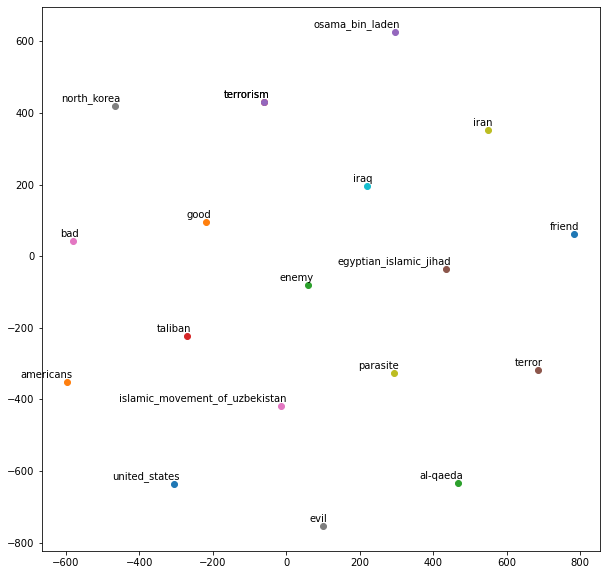

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, set_array):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print('creating tokens and labels')
#     for word in model.wv.key_to_index:
#         tokens.append(model.wv[word])
#         labels.append(word)
        
    for word in set_array:
        if word in model.wv.index_to_key:
            tokens.append(model.wv[word])
            labels.append(word)
            
    print(f'Total terms {len(labels)}')
    
    
    print('building tsne model')
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    print('constructing graph')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
        if labels[i] in set_array:
            plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
            
    plt.savefig('vector_distribution.png')
    plt.show()

print(f'input terms: {len(total)}')
total = [model.normaliser.transform_word(word) for word in total]
tsne_plot(model, total)

creating tokens and labels
Total terms 195
building tsne model
constructing graph


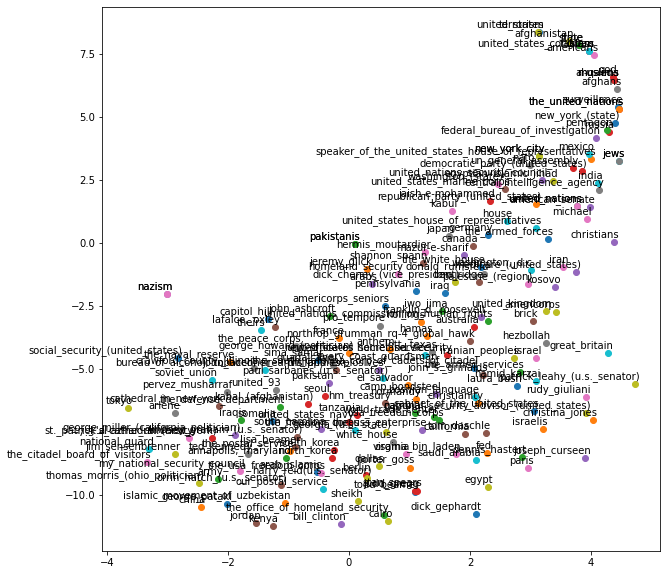

In [34]:
normalised_entities = [model.normaliser.transform_word(word) for word in doc_array.group_ents]
tsne_plot(model, normalised_entities)

In [81]:
outgroups = ['al-Qaeda']
seed_terms = ['terrorism', 'terror', 'terrorist', 'murder', 'regime']

data = {}
for term in terms_array:
    data[term] = {}
    count = 0
    
    term_normalised = ent_normaliser.transform_word(term)
    
    for sentence in doc_array:
        if term_normalised in sentence:
            count += 1
    data[term]['Mention Count'] = count
    
df1 = pd.DataFrame(data)
dfi.export(df1, 'representations.png')

columns = ['Seed Terms']
df2 = pd.DataFrame(seed_terms_bad, columns=columns).T
    
def get_word_contexts(iterable, terms_of_interest, seed_terms):
    
    for sentence in iterable:
            
        for term in terms_of_interest:

            term = ent_normaliser.transform_word(term)

            if term in sentence:

                index = sentence.index(term)
                
                window = 5

                if index - window >= 0:
                    left = index - window
                else:
                    left = 0

                window = window + 1
                
                if index + window <= len(sentence):
                    right = index + window
                else:
                    right = len(sentence)

                new_sent = [token for token in sentence[left : right]]
                new_sent_set = set(new_sent)
                seed_terms = set(seed_terms)
                
                term_index = new_sent.index(term)
                for x in range(1, window - term_index):
                    new_sent.insert(0, '')
                                
                if seed_terms.intersection(new_sent_set):
                    new_sent.insert(0, True)
                else:
                    new_sent.insert(0, False)
                    
                yield new_sent

terms_array = ['United States', 'Americans', 'al-Qaeda', 'Taliban', 'terrorist', 'enemy', 'murderer']

data = list(get_word_contexts(doc_array.__iter__(lemma=False), outgroups, seed_terms))
columns = ['Co-Occuring with seed term?'] + [x + 1 for x in range(-6, 5)]
index = [f'Sentence {x}' for x in range(1, len(data) + 1)]
df3 = pd.DataFrame(data, index=index, columns=columns).fillna(value='')
                
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', None):
    
    display(df1, df2, df3)

objc[35392]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x112c05668). One of the two will be used. Which one is undefined.
[1012/174854.734678:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpyf7_6h95/temp.png.


,United States,Americans,al-Qaeda,Taliban,terrorist,enemy,murderer
Mention Count,187,37,16,25,118,41,7


,0,1,2,3,4,5,6
Seed Terms,enemy,terrorism,terrorist,terror,bad,evil,parasite


,Co-Occuring with seed term?,-5,-4,-3,-2,-1,0,1,2,3,4,5
Sentence 1,True,loosely,affiliated,terrorism,organizations,known,al-qaeda,,,,,
Sentence 2,True,,,,,,al-qaeda,terror,mafia,crime,,
Sentence 3,False,,,,,leadership,al-qaeda,great,influence,afghanistan,supports,taliban
Sentence 4,False,,,,,afghanistan,al-qaeda,vision,world,,,
Sentence 5,False,taliban,deliver,united_states,authorities,leaders,al-qaeda,hide,land,,,
Sentence 6,True,,,war,terror,begins,al-qaeda,end,,,,
Sentence 7,True,orders,united_states,military,begun,strikes,al-qaeda,terrorism,training,camps,military,installations
Sentence 8,True,terrorism,training,camps,hand,leaders,al-qaeda,network,return,foreign,nationals,including
Sentence 9,True,eliminating,power,centers,regime,harbors,al-qaeda,terrorists,,,,
Sentence 10,False,,,,,today,al-qaeda,taliban,shelter,,,


In [ ]:
terms_array = ['United States', 'Americans', 'al-Qaeda', 'Taliban', 'terrorist', 'enemy', 'murderer']

data = {}
for term in terms_array:
    data[term] = {}
    count = 0
    
    term_normalised = term.replace(" ", '_').lower()
    
    for sentence in doc_array.sentences:
        if term_normalised in sentence:
            count += 1
    data[term]['Occurrence Count'] = count
    
display(pd.DataFrame(data))

In [ ]:
for sentence in doc_array:
    print(sentence)